<a href="https://colab.research.google.com/github/Zaybatsus/gridSearch_GPU/blob/main/Grid_com_medica_tempo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [16]:
import numpy as np
import scipy.io
from scipy import signal
from scipy.ndimage import rotate
from cupyx.scipy.signal import convolve2d

In [17]:
# Simula ruído de fótons em uma imagem baseada em uma probabilidade definida pela intensidade da imagem original.

def photon_shower(datain, photons):

    n, m = datain.shape
    dataout = np.zeros((n, m), dtype=int)
    i = 0

    while i < photons:
        phx = int(np.random.rand() * m)
        phy = int(np.random.rand() * n)
        phz = np.random.rand()

        if phz < datain[phy, phx]:
            dataout[phy, phx] += 1
            i += 1
    return dataout

In [18]:
  # Essa função tem a intenção de gerar imagem simulada de uma subabertura usando:
  #   -	Um perfil gaussiano para o ponto de luz.
  #   -	Um grid linear para representar o alongamento da fonte de luz.
  #   -	Convolução 2D para integrar as características ópticas.
  #   -	Simula a aquisição da câmera, incluindo a redução de resolução e a quantização dos níveis de brilho.

def subabertura(profile, elongation, posy, posx, photons, sky, angle, bits, reducao, subappix):
    Gauss = np.zeros((subappix+1, subappix+1))
    xc = ((subappix / 2) + 1) + posx * 10
    yc = ((subappix / 2) + 1) + posy * 10
    sig = 8

    X, Y = np.meshgrid(np.arange(1, subappix+2), np.arange(1, subappix+2))
    Gauss = np.exp(-((X - xc)**2 / (2 * sig**2) + (Y - yc)**2 / (2 * sig**2)))

    LineGrid = np.zeros((subappix+1, subappix+1))
    sizep = len(profile)
    resize = sizep / (elongation * 10.0)

    summ = 0
    indexchange = resize
    x = (subappix // 2 + 1) - elongation * 5

    for i in range(1, sizep+1):
            if i <= indexchange:
                summ += profile[i-1]
                if i == sizep -1:
                    LineGrid[subappix // 2, x] = summ / 2.0
                    LineGrid[subappix // 2 + 1, x] = summ / 2.0
            else:
                summ += profile[i-1] * (indexchange - int(indexchange))
                LineGrid[subappix // 2, x] = summ / 2.0
                LineGrid[subappix // 2 + 1, x] = summ / 2.0

                summ = profile[i-1] * (1 - indexchange + int(indexchange))
                indexchange += resize
                x += 1

    if angle != 0:
        LineGrid = rotate(LineGrid, angle, reshape=False)


    HRgrid = signal.convolve2d(Gauss, LineGrid, mode='same')
    HRgrid = HRgrid / np.max(HRgrid)


    if photons > 0:
        HRgrid = photon_shower(HRgrid, photons)


    pixels = np.zeros((reducao, reducao))

    for y in range(reducao):
        for x in range(reducao):
            pixels[y, x] = np.sum(HRgrid[y*10:(y+1)*10, x*10:(x+1)*10])


    skyph = np.ones((reducao, reducao))
    pixels += photon_shower(skyph, sky)

    subap = np.zeros((reducao, reducao))
    div = (2**bits) / np.max(pixels) * 0.9
    for i in range(reducao):
        for j in range(reducao):
            #subap[i, j] = pixels[i, j] * div
            subap[i, j] = np.fix(pixels[i, j] * div)
    return subap

Aplicação direta do método de grid search em GPU

> Neste caso foi usado a biblioteca cupy, porém não está sendo determinado a separação do grid em theads e blocos para ter a paralelização, é apenas uma trasnformação direta para GPU.



In [19]:
import cupy as cp
from cupyx.scipy.ndimage import shift

def gpu_semParalelizar(im, simim_base, fim):

    im = cp.asarray(im, dtype=cp.float32)
    simim_base = cp.asarray(simim_base, dtype=cp.float32)
    fim = cp.asarray(fim, dtype=cp.float32)

    step = 256
    slopes_x, slopes_y = cp.meshgrid(cp.linspace(-8, 8, step), cp.linspace(-8, 8, step))
    slopes = cp.column_stack((slopes_x.ravel(), slopes_y.ravel()))
    hp = slopes.shape[0]
    e = cp.zeros(hp)


    for k in range(hp):

        shifted_simim = shift(simim_base, shift=[slopes[k, 1], slopes[k, 0]], mode='constant', cval=0)

        max_val = cp.max(shifted_simim)
        if max_val > 0:
            shifted_simim /= max_val
        else:
            shifted_simim = cp.zeros_like(shifted_simim)

        shifted_simim = cp.clip(shifted_simim, 0, None)

        e[k] = cp.sum(-shifted_simim + im * cp.log(cp.clip(shifted_simim, 1e-10, None))) - cp.sum(cp.log(fim))

    i = cp.argmax(e)
    posx = slopes[i, 0]
    posy = slopes[i, 1]

    return float(posx), float(posy)

Usando Cupy aplicando - Raw Kernel

> Usando este método não está funcionando corretamente, realizando a paralelização, parece está deslocando a imagem conforme o método grid search, porém parece que há um erro no cálculo do erro minimo. A aplicação do método de grid search paralelizado está no final do código usando NUMBA



In [20]:
import cupy as cp

shift_kernel = cp.RawKernel(r'''
extern "C" __global__
void shift(const float* img, const float* sim_img, const float* fim,
                             float* e, int width, int height, float dx, float dy) {

    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x >= width || y >= height) return;

    // Coordenadas inversas com deslocamento
    float src_x = x - dx;
    float src_y = y - dy;

    // Verifica se estao dentro dos limites
    if (src_x < 0 || src_x >= width - 1 || src_y < 0 || src_y >= height - 1) {
        e[y * width + x] = 0.0;
        return;
    }

    // Coordenadas inteiras e fracionarias para interpolacao
    int x0 = (int)src_x;
    int y0 = (int)src_y;
    float fx = src_x - x0;
    float fy = src_y - y0;

    // Pixels ao redor
    float p00 = sim_img[y0 * width + x0];
    float p01 = sim_img[(y0 + 1) * width + x0];
    float p10 = sim_img[y0 * width + (x0 + 1)];
    float p11 = sim_img[(y0 + 1) * width + (x0 + 1)];

    // Interpolacao bilinear
    float shifted_simim = (1 - fx) * (1 - fy) * p00 +
                          (1 - fx) * fy * p01 +
                          fx * (1 - fy) * p10 +
                          fx * fy * p11;

    shifted_simim = fmaxf(shifted_simim, 1e-10f);

    // Calcular o erro
    float im_val = img[y * width + x];
    float fim_val = fim[y * width + x];
    e[y * width + x] = expf(-shifted_simim) * powf(shifted_simim, im_val) / fim_val;
}
''', 'shift')

def grid_rawKernel(img, sim_img, fim):

    height, width = img.shape

    # Colocando as imagens em GPU
    img = cp.asarray(img, dtype=cp.float32)
    sim_img = cp.asarray(sim_img, dtype=cp.float32)
    fim = cp.asarray(fim, dtype=cp.float32)

    # Criando a grade de busca
    step = 256
    slopes_x, slopes_y = cp.meshgrid(cp.linspace(-8, 8, step),
                                     cp.linspace(-8, 8, step))
    slopes = cp.column_stack((slopes_x.ravel(), slopes_y.ravel()))
    hp = slopes.shape[0]

    # Alocar vetor de erros
    e = cp.zeros((height, width), dtype=cp.float32)

    # Configurar o numero de blocos e threads
    threads_per_block = (16, 16)
    num_blocks_x = (width + threads_per_block[0] - 1) // threads_per_block[0]
    num_blocks_y = (height + threads_per_block[1] - 1) // threads_per_block[1]

    # Execução do kernel
    max_error = float('-inf')
    max_index = None
    posx, posy = 0, 0

    for dx, dy in slopes:
        shift_kernel((num_blocks_x, num_blocks_y), threads_per_block,
                     (img, sim_img, fim, e, width, height, float(dx), float(dy)))

    max_error = cp.max(e)
    max_index = cp.argmax(e)
    posx, posy = slopes[max_index]


    return float(posx), float(posy), float(max_error)


Fluxo Principal

Simulando para posição: x = -0.5000000000000004, y = 0.5000000000000004
Tempo de execução do Raw Kernel: 4.746219 segundos
Tempo de execução somente GPU: 65.451003 segundos
Posição encontrada pelo Raw Kernel: x = -8.0, y = -8.0
Posição encontrada somente GPU: x = -0.6588235294117648, y = 0.5333333333333332
Erro estimado pelo Raw Kernel: 11.335784048754634
Erro estimado somente GPU: 0.16228377801222355


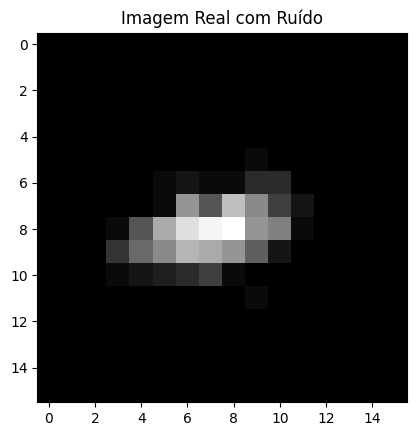

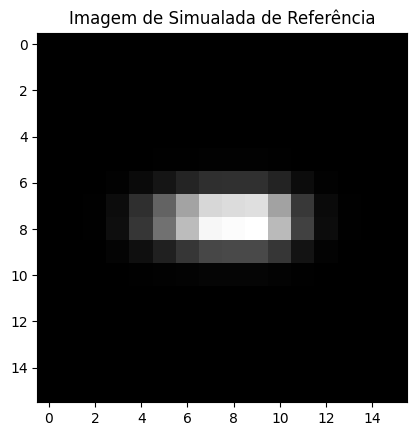

In [21]:
from scipy.special import gamma
import time
import matplotlib.pyplot as plt

# Carregar o perfil
data = scipy.io.loadmat('/content/profile.mat')
profile = data['profile'].flatten()

# Parâmetros fixos
photons = 300
sky = 0
elongation = 8
angle = 15
bits = 16
subappix = 160
reducao = 16

# Vetor de posições reais para referência
realslopes = np.array([(0.75 - np.arange(1, 17) / 10) * 10, (-0.75 + np.arange(1, 17) / 10) * 10]).T
GDHslopes = np.zeros((16, 2))

# Definir a posição específica onde a estrela estará
posicao_index = 7
posicao_x, posicao_y = realslopes[posicao_index]

# Gerar as imagens
print(f"Simulando para posição: x = {posicao_x}, y = {posicao_y}")
img = subabertura(profile, elongation, posicao_y, posicao_x, photons, sky, angle, bits, reducao, subappix)
simim_base = subabertura(profile, elongation, 0, 0, 0, 0, 0, bits, reducao, subappix)

# Normalizar dados
im = img / np.max(img)
simim_base = simim_base / np.max(simim_base)
fim = gamma(im + 1)

# Aplicando o método
start_time = time.time()
cenx, ceny, e = grid_rawKernel(im, simim_base, fim)
end_time = time.time()
time_grid_rawKernel = end_time - start_time
print(f"Tempo de execução do Raw Kernel: {time_grid_rawKernel:.6f} segundos")

start_time = time.time()
cenx_s, ceny_s = gpu_semParalelizar(im, simim_base, fim)
end_time = time.time()
time_gpu_semParalelizar = end_time - start_time
print(f"Tempo de execução somente GPU: {time_gpu_semParalelizar:.6f} segundos")


print(f"Posição encontrada pelo Raw Kernel: x = {cenx}, y = {ceny}")
print(f"Posição encontrada somente GPU: x = {cenx_s}, y = {ceny_s}")


#Calcular o erro
slope_difference = (np.array([posicao_y, posicao_x]) - np.array([ceny, cenx]))**2
erro = np.sqrt(np.sum(slope_difference))

slope_difference2 = (np.array([posicao_y, posicao_x]) - np.array([ceny_s, cenx_s]))**2
erro2 = np.sqrt(np.sum(slope_difference2))

print(f"Erro estimado pelo Raw Kernel: {erro}")
print(f"Erro estimado somente GPU: {erro2}")

plt.imshow(img, cmap='gray')
plt.title("Imagem Real com Ruído")
plt.show()

plt.imshow(simim_base, cmap='gray')
plt.title("Imagem de Simualada de Referência")
plt.show()

Numba CUDA

> Usando a blibioteca NUMBA fazer a paralelização



In [27]:
import numpy as np
import scipy.io
from numba import cuda, float32, config
config.CUDA_ENABLE_PYNVJITLINK = 1
config.CUDA_LOW_OCCUPANCY_WARNINGS = 0
import math
from scipy.special import gamma
import time


@cuda.jit
def compute_error(im, simim_base, fim, slopes_x, slopes_y, e):
    i = cuda.grid(1)  # Determina o índice único da thread
    n = slopes_x.size

    if i < n:
        dx = slopes_x[i]
        dy = slopes_y[i]

        # Inicialização dos valores locais
        error = 1.0
        max_val = float32(0.0)

        rows, cols = simim_base.shape

        # Calcula o valor máximo deslocado com interpolação bilinear
        for x in range(rows):
            for y in range(cols):
                new_x = x + dx
                new_y = y + dy

                if 0 <= new_x < rows - 1 and 0 <= new_y < cols - 1:
                    # Interpolação bilinear
                    x0, y0 = int(new_x), int(new_y)
                    x1, y1 = x0 + 1, y0 + 1

                    fx = new_x - x0
                    fy = new_y - y0

                    # Valores interpolados
                    val = (1 - fx) * (1 - fy) * simim_base[x0, y0] + \
                          fx * (1 - fy) * simim_base[x1, y0] + \
                          (1 - fx) * fy * simim_base[x0, y1] + \
                          fx * fy * simim_base[x1, y1]
                else:
                    val = 0.0

                max_val = max(max_val, val)

        if max_val > 0:
            # Normaliza e calcula o erro acumulado
            for x in range(rows):
                for y in range(cols):
                    new_x = x + dx
                    new_y = y + dy

                    if 0 <= new_x < rows - 1 and 0 <= new_y < cols - 1:
                        # Interpolação bilinear
                        x0, y0 = int(new_x), int(new_y)
                        x1, y1 = x0 + 1, y0 + 1

                        fx = new_x - x0
                        fy = new_y - y0

                        # Valores interpolados
                        shifted_val = (1 - fx) * (1 - fy) * simim_base[x0, y0] + \
                                      fx * (1 - fy) * simim_base[x1, y0] + \
                                      (1 - fx) * fy * simim_base[x0, y1] + \
                                      fx * fy * simim_base[x1, y1]
                        shifted_val /= max_val
                    else:
                        shifted_val = 0.0

                    error *= math.exp(-shifted_val) * (shifted_val ** im[x, y]) / fim[x, y]

        e[i] = error


# Carregar o perfil
data = scipy.io.loadmat('/content/profile.mat')
profile = data['profile'].flatten()

# Parâmetros fixos
photons = 300
sky = 0
elongation = 8
angle = 15
bits = 16
subappix = 160
reducao = 16

# Vetor de posições reais
realslopes = np.array([(0.75 - np.arange(1, 17) / 10) * 10, (-0.75 + np.arange(1, 17) / 10) * 10]).T
posicao_index = 7
posicao_x, posicao_y = realslopes[posicao_index]

# Gerar as imagens usando subabertura
print(f"Simulando para posição: x = {posicao_x}, y = {posicao_y}")
img = subabertura(profile, elongation, posicao_y, posicao_x, photons, sky, angle, bits, reducao, subappix)
simim_base = subabertura(profile, elongation, 0, 0, 0, 0, 0, bits, reducao, subappix)

# Normalizar as imagens
im = img / np.max(img)
simim_base = simim_base / np.max(simim_base)
fim = gamma(im + 1)

# Definir grid para varredura
step = 256
slopes_x = np.linspace(-8, 8, step)
slopes_y = np.linspace(-8, 8, step)
slopes_x, slopes_y = np.meshgrid(slopes_x, slopes_y)
slopes_x = slopes_x.ravel()
slopes_y = slopes_y.ravel()
hp = slopes_x.size
e = np.zeros(hp, dtype=np.float32)

# Configurar blocos e threads
threads_per_block = 128
blocks_per_grid = (hp + threads_per_block - 1) // threads_per_block


start = cuda.event()
end = cuda.event()

# Chamar a função compute_error
start.record()
compute_error[blocks_per_grid, threads_per_block](im, simim_base, fim, slopes_x, slopes_y, e)
end.record()


cuda.synchronize()
elapsed_time = start.elapsed_time(end)  # Tempo em milissegundos

# Encontrar a posição com menor erro
max_idx = np.argmax(e)
cenx, ceny = slopes_x[max_idx], slopes_y[max_idx]

# Calcular o erro estimado
slope_difference = (np.array([posicao_y, posicao_x]) - np.array([ceny, cenx]))**2
erro = np.sqrt(np.sum(slope_difference))

print(f"Posição encontrada: x = {cenx}, y = {ceny}")
print(f"Erro estimado: {erro}")
print(f"Tempo de execução do compute_error: {elapsed_time:.3f} ms")


Simulando para posição: x = -0.5000000000000004, y = 0.5000000000000004


ERROR:numba.cuda.cudadrv.driver:Call to cuLinkAddData results in CUDA_ERROR_UNSUPPORTED_PTX_VERSION


LinkerError: [222] Call to cuLinkAddData results in CUDA_ERROR_UNSUPPORTED_PTX_VERSION
ptxas application ptx input, line 9; fatal   : Unsupported .version 8.5; current version is '8.4'